# 1-1,结构化数据建模流程范例

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

from python_cgtools.utils_date import *

In [4]:
start_time = time.time()
print_with_time("start.........")

2023-05-26 23:20:07:start.........


In [5]:
fix_all_seed(13)

tensorflow sed random seed fail.


In [6]:
# !pip install torch==1.10.0
# !pip install torchkeras==3.2.3

In [7]:
# import torch 
# import torchkeras 
# print("torch.__version__ = ", torch.__version__)
# print("torchkeras.__version__ = ", torchkeras.__version__) 

```
torch.__version__ =  1.10.0
torchkeras.__version__ =  3.2.3
```

<br>

<font color="red">
 
公众号 **算法美食屋** 回复关键词：**pytorch**， 获取本项目源码和所用数据集百度云盘下载链接。
    
</font> 


### 一，准备数据

titanic数据集的目标是根据乘客信息预测他们在Titanic号撞击冰山沉没后能否生存。

结构化数据一般会使用Pandas中的DataFrame进行预处理。


In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset

dftrain_raw = pd.read_csv('./eat_pytorch_datasets/titanic/train.csv')
dftest_raw = pd.read_csv('./eat_pytorch_datasets/titanic/test.csv')
dftrain_raw.head(10)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


![](./data/1-1-数据集展示.jpg)

字段说明：

* Survived:0代表死亡，1代表存活【y标签】
* Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
* Name:乘客姓名 【舍去】
* Sex:乘客性别 【转换成bool特征】
* Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
* SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
* Parch:乘客父母/孩子的个数(整数值)【数值特征】
* Ticket:票号(字符串)【舍去】
* Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
* Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
* Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】


利用Pandas的数据可视化功能我们可以简单地进行探索性数据分析EDA（Exploratory Data Analysis）。

label分布情况

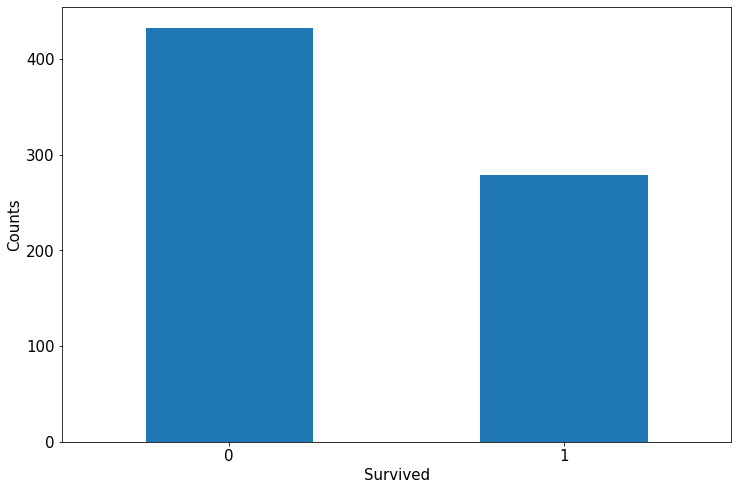

In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Survived'].value_counts().plot(kind = 'bar',
     figsize = (12,8),fontsize=15,rot = 0)
ax.set_ylabel('Counts',fontsize = 15)
ax.set_xlabel('Survived',fontsize = 15)
plt.show()


![](./data/1-1-Label分布.jpg)

年龄分布情况

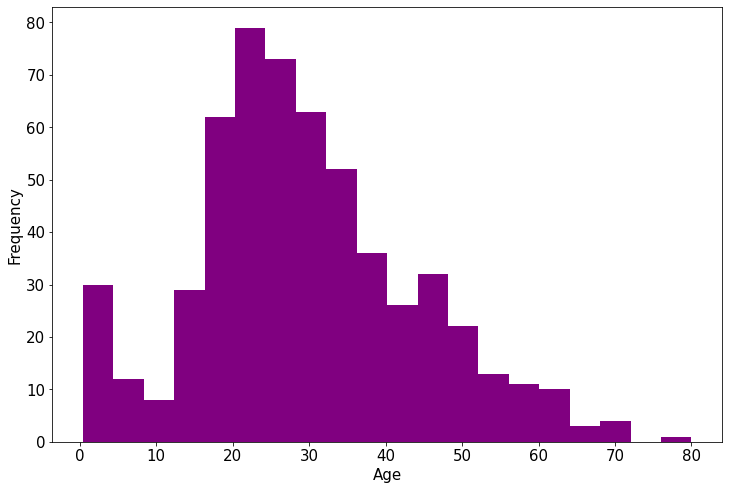

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw['Age'].plot(kind = 'hist',bins = 20,color= 'purple',
                    figsize = (12,8),fontsize=15)

ax.set_ylabel('Frequency',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()


![](./data/1-1-年龄分布.jpg)

年龄和label的相关性

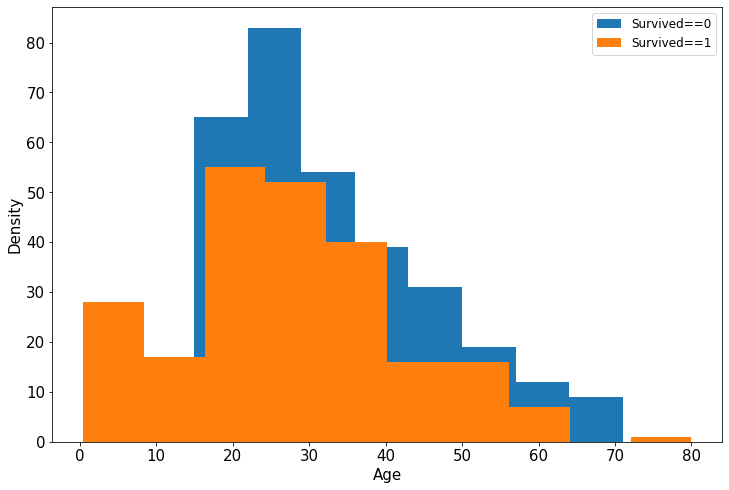

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'hist',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'hist',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

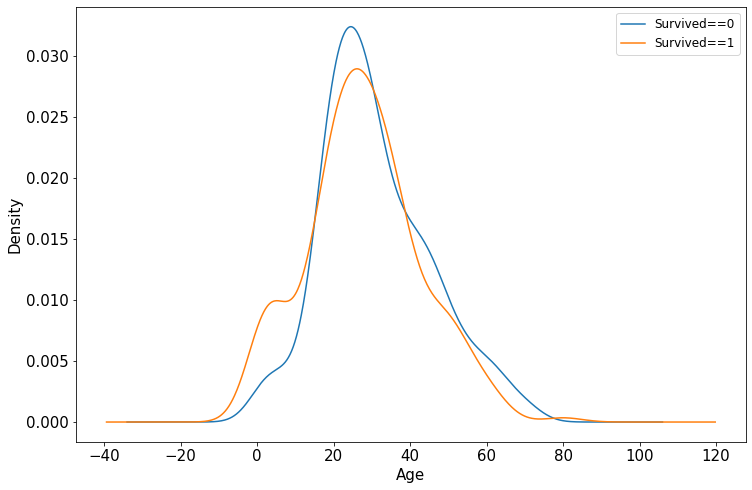

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
ax = dftrain_raw.query('Survived == 0')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
dftrain_raw.query('Survived == 1')['Age'].plot(kind = 'density',
                      figsize = (12,8),fontsize=15)
ax.legend(['Survived==0','Survived==1'],fontsize = 12)
ax.set_ylabel('Density',fontsize = 15)
ax.set_xlabel('Age',fontsize = 15)
plt.show()

![](./data/1-1-年龄相关性.jpg)

下面为正式的数据预处理

In [13]:
def preprocessing(dfdata):

    dfresult= pd.DataFrame()

    #Pclass
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ]
    dfresult = pd.concat([dfresult,dfPclass],axis = 1)

    #Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult,dfSex],axis = 1)

    #Age
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32')

    #SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']

    #Carbin
    dfresult['Cabin_null'] =  pd.isna(dfdata['Cabin']).astype('int32')

    #Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'],dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult,dfEmbarked],axis = 1)

    return(dfresult)

x_train_df = preprocessing(dftrain_raw)
x_train = x_train_df.values
y_train = dftrain_raw[['Survived']].values

x_test = preprocessing(dftest_raw).values
y_test = dftest_raw[['Survived']].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )


x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)


```
x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712, 1)
y_test.shape = (179, 1)
```

In [14]:
x_train_df.head(30)

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0
5,0,1,0,1,0,55.0,0,0,0,16.0000,1,0,0,1,0
6,0,0,1,0,1,20.5,0,0,0,7.2500,1,0,0,1,0
7,0,1,0,0,1,28.0,0,0,0,10.5000,1,0,0,1,0
8,0,0,1,1,0,45.0,0,1,4,27.9000,1,0,0,1,0
9,0,0,1,0,1,6.0,0,0,1,12.4750,0,0,0,1,0


In [15]:
x_train_df

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707,0,0,1,1,0,24.0,0,0,3,19.2583,1,1,0,0,0
708,1,0,0,0,1,0.0,1,0,0,27.7208,1,1,0,0,0
709,0,0,1,0,1,45.0,0,0,0,6.9750,1,0,0,1,0
710,0,1,0,0,1,35.0,0,0,0,26.0000,1,0,0,1,0


In [16]:
# 如果 tensor 中不表明 dtype，表示是默认数据类型，其中浮点数是 float32, int 是 int64
torch.tensor(x_train)#.double()

tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 1., 0.]], dtype=torch.float64)

In [17]:
# .float() 相当于从个float64(double) 转化为 float32
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()),
                     shuffle = True, batch_size = 8)
dl_val = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()),
                     shuffle = False, batch_size = 8)


进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。

In [18]:
# 测试数据管道
# 注意，输出都是 tensor
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   1.0000,   0.0000,
           4.0000,   1.0000,  39.6875,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  20.0000,   0.0000,
           1.0000,   1.0000,  15.7417,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  33.0000,   0.0000,
           1.0000,   0.0000,  90.0000,   0.0000,   0.0000,   1.0000,   0.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  18.0000,   0.0000,
           1.0000,   0.0000,   6.4958,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000,   7.2250,   1.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000, 22

```
tensor([[  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000,   7.8958,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   1.0000,
           0.0000,   0.0000,  30.5000,   0.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   1.0000,   0.0000,  31.0000,   0.0000,
           1.0000,   0.0000, 113.2750,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  60.0000,   0.0000,
           0.0000,   0.0000,  26.5500,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  28.0000,   0.0000,
           0.0000,   0.0000,  22.5250,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000,   1.0000,  32.0000,   0.0000,
           0.0000,   0.0000,   8.3625,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  0.0000,   1.0000,   0.0000,   1.0000,   0.0000,  28.0000,   0.0000,
           0.0000,   0.0000,  13.0000,   1.0000,   0.0000,   0.0000,   1.0000,
           0.0000],
        [  1.0000,   0.0000,   0.0000,   0.0000,   1.0000,  36.0000,   0.0000,
           0.0000,   1.0000, 512.3292,   0.0000,   1.0000,   0.0000,   0.0000,
           0.0000]]) tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.]])
```

### 二，定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择使用最简单的nn.Sequential，按层顺序模型。

In [19]:
# Sequential(
#   (linear1): Linear(in_features=15, out_features=20, bias=True)
#   (relu1): ReLU()
#   (linear2): Linear(in_features=20, out_features=15, bias=True)
#   (relu2): ReLU()
#   (linear3): Linear(in_features=15, out_features=1, bias=True)
# )
def create_net():
    net = nn.Sequential()
    net.add_module("linear1",nn.Linear(15,20))
    net.add_module("relu1",nn.ReLU())
    net.add_module("linear2",nn.Linear(20,15))
    net.add_module("relu2",nn.ReLU())
    net.add_module("linear3",nn.Linear(15,1))
    return net
    
net = create_net()
print(net)

Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
)


### 三，训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的仿照Keras风格的脚本形式的训练循环。

该脚本形式的训练代码与 torchkeras 库的核心代码基本一致。

torchkeras详情:  https://github.com/lyhue1991/torchkeras 


In [20]:
import os,sys,time
import numpy as np
import pandas as pd
import datetime 
from tqdm import tqdm 

import torch
from torch import nn 
from copy import deepcopy
from torchkeras.metrics import Accuracy


def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(str(info)+"\n")
    

loss_fn = nn.BCEWithLogitsLoss()
optimizer= torch.optim.Adam(net.parameters(),lr = 0.01)   
metrics_dict = {"acc":Accuracy()}

epochs = 20 
ckpt_path='checkpoint.pt'

#early_stopping相关设置
monitor="val_acc"
patience=5
mode="max"

history = {}

for epoch in range(1, epochs+1):
    printlog("Epoch {0} / {1}".format(epoch, epochs))

    # 1，train -------------------------------------------------  
    net.train()
    
    total_loss,step = 0,0
    
    loop = tqdm(enumerate(dl_train), total =len(dl_train))
    train_metrics_dict = deepcopy(metrics_dict) 
    
    for i, batch in loop: 
        
        features,labels = batch
        #forward
        preds = net(features)
        loss = loss_fn(preds,labels)
        
        #backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
            
        #metrics
        step_metrics = {"train_"+name:metric_fn(preds, labels).item() 
                        for name,metric_fn in train_metrics_dict.items()}
        
        step_log = dict({"train_loss":loss.item()},**step_metrics)

        total_loss += loss.item()
        
        step+=1
        if i!=len(dl_train)-1:
            loop.set_postfix(**step_log)
        else:
            epoch_loss = total_loss/step
            epoch_metrics = {"train_"+name:metric_fn.compute().item() 
                             for name,metric_fn in train_metrics_dict.items()}
            epoch_log = dict({"train_loss":epoch_loss},**epoch_metrics)
            loop.set_postfix(**epoch_log)

            for name,metric_fn in train_metrics_dict.items():
                metric_fn.reset()
                
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]
        

    # 2，validate -------------------------------------------------
    net.eval()
    
    total_loss,step = 0,0
    loop = tqdm(enumerate(dl_val), total =len(dl_val))
    
    val_metrics_dict = deepcopy(metrics_dict) 
    
    with torch.no_grad():
        for i, batch in loop: 

            features,labels = batch
            
            #forward
            preds = net(features)
            loss = loss_fn(preds,labels)

            #metrics
            step_metrics = {"val_"+name:metric_fn(preds, labels).item() 
                            for name,metric_fn in val_metrics_dict.items()}

            step_log = dict({"val_loss":loss.item()},**step_metrics)

            total_loss += loss.item()
            step+=1
            if i!=len(dl_val)-1:
                loop.set_postfix(**step_log)
            else:
                epoch_loss = (total_loss/step)
                epoch_metrics = {"val_"+name:metric_fn.compute().item() 
                                 for name,metric_fn in val_metrics_dict.items()}
                epoch_log = dict({"val_loss":epoch_loss},**epoch_metrics)
                loop.set_postfix(**epoch_log)

                for name,metric_fn in val_metrics_dict.items():
                    metric_fn.reset()
                    
    epoch_log["epoch"] = epoch           
    for name, metric in epoch_log.items():
        history[name] = history.get(name, []) + [metric]

    # 3，early-stopping -------------------------------------------------
    arr_scores = history[monitor]
    best_score_idx = np.argmax(arr_scores) if mode=="max" else np.argmin(arr_scores)
    if best_score_idx==len(arr_scores)-1:
        torch.save(net.state_dict(),ckpt_path)
        print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
             arr_scores[best_score_idx]),file=sys.stderr)
    if len(arr_scores)-best_score_idx>patience:
        print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
            monitor,patience),file=sys.stderr)
        break 
    net.load_state_dict(torch.load(ckpt_path))
    
dfhistory = pd.DataFrame(history)


torchkeras.LightModel can't be used!



================================================================================2023-05-26 23:20:16
Epoch 1 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.97it/s, val_acc=0.715, val_loss=0.518]
<<<<<< reach best val_acc : 0.7150837779045105 >>>>>>



================================================================================2023-05-26 23:20:16
Epoch 2 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.11it/s, val_acc=0.788, val_loss=0.474]
<<<<<< reach best val_acc : 0.7877094745635986 >>>>>>



================================================================================2023-05-26 23:20:16
Epoch 3 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.96it/s, val_acc=0.793, val_loss=0.432]
<<<<<< reach best val_acc : 0.7932960987091064 >>>>>>



================================================================================2023-05-26 23:20:17
Epoch 4 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.97it/s, val_acc=0.793, val_loss=0.438]



================================================================================2023-05-26 23:20:17
Epoch 5 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.98it/s, val_acc=0.804, val_loss=0.428]
<<<<<< reach best val_acc : 0.8044692873954773 >>>>>>



================================================================================2023-05-26 23:20:17
Epoch 6 / 20



100%|███████████████████████████████████████████████████| 23/23 [00:00<00:00, 922.44it/s, val_acc=0.81, val_loss=0.436]
<<<<<< reach best val_acc : 0.8100558519363403 >>>>>>



================================================================================2023-05-26 23:20:17
Epoch 7 / 20



100%|███████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.99it/s, val_acc=0.81, val_loss=0.445]



================================================================================2023-05-26 23:20:17
Epoch 8 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 854.12it/s, val_acc=0.782, val_loss=0.429]



================================================================================2023-05-26 23:20:18
Epoch 9 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 886.99it/s, val_acc=0.793, val_loss=0.399]



================================================================================2023-05-26 23:20:18
Epoch 10 / 20



100%|██████████████████████████████████████████████████| 23/23 [00:00<00:00, 922.46it/s, val_acc=0.788, val_loss=0.421]



================================================================================2023-05-26 23:20:18
Epoch 11 / 20



100%|█████████████████████████████████████████████████| 23/23 [00:00<00:00, 1002.68it/s, val_acc=0.793, val_loss=0.414]
<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>


```
================================================================================2022-07-10 21:55:18
Epoch 1 / 20

100%|██████████| 89/89 [00:00<00:00, 192.16it/s, train_acc=0.664, train_loss=0.646]
100%|██████████| 23/23 [00:00<00:00, 252.37it/s, val_acc=0.721, val_loss=0.571]
<<<<<< reach best val_acc : 0.7206704020500183 >>>>>>

================================================================================2022-07-10 21:55:19
Epoch 2 / 20

100%|██████████| 89/89 [00:00<00:00, 212.44it/s, train_acc=0.725, train_loss=0.576]
100%|██████████| 23/23 [00:00<00:00, 183.68it/s, val_acc=0.726, val_loss=0.503]
<<<<<< reach best val_acc : 0.7262569665908813 >>>>>>

================================================================================2022-07-10 21:55:19
Epoch 3 / 20

100%|██████████| 89/89 [00:00<00:00, 128.57it/s, train_acc=0.772, train_loss=0.517]
100%|██████████| 23/23 [00:00<00:00, 195.21it/s, val_acc=0.782, val_loss=0.445]
<<<<<< reach best val_acc : 0.7821229100227356 >>>>>>

================================================================================2022-07-10 21:55:20
Epoch 4 / 20

100%|██████████| 89/89 [00:00<00:00, 139.91it/s, train_acc=0.784, train_loss=0.495]
100%|██████████| 23/23 [00:00<00:00, 281.71it/s, val_acc=0.793, val_loss=0.435]
<<<<<< reach best val_acc : 0.7932960987091064 >>>>>>

================================================================================2022-07-10 21:55:21
Epoch 5 / 20

100%|██████████| 89/89 [00:00<00:00, 216.33it/s, train_acc=0.788, train_loss=0.493]
100%|██████████| 23/23 [00:00<00:00, 246.54it/s, val_acc=0.81, val_loss=0.409]
<<<<<< reach best val_acc : 0.8100558519363403 >>>>>>

================================================================================2022-07-10 21:55:21
Epoch 6 / 20

100%|██████████| 89/89 [00:00<00:00, 191.69it/s, train_acc=0.765, train_loss=0.481]
100%|██████████| 23/23 [00:00<00:00, 251.35it/s, val_acc=0.777, val_loss=0.436]

================================================================================2022-07-10 21:55:22
Epoch 7 / 20

100%|██████████| 89/89 [00:00<00:00, 192.42it/s, train_acc=0.781, train_loss=0.493]
100%|██████████| 23/23 [00:00<00:00, 241.61it/s, val_acc=0.771, val_loss=0.462]

================================================================================2022-07-10 21:55:22
Epoch 8 / 20

100%|██████████| 89/89 [00:00<00:00, 211.52it/s, train_acc=0.801, train_loss=0.475]
100%|██████████| 23/23 [00:00<00:00, 263.07it/s, val_acc=0.793, val_loss=0.406]

================================================================================2022-07-10 21:55:23
Epoch 9 / 20

100%|██████████| 89/89 [00:00<00:00, 199.20it/s, train_acc=0.798, train_loss=0.444]
100%|██████████| 23/23 [00:00<00:00, 265.92it/s, val_acc=0.782, val_loss=0.43]

================================================================================2022-07-10 21:55:23
Epoch 10 / 20

100%|██████████| 89/89 [00:00<00:00, 193.12it/s, train_acc=0.81, train_loss=0.445] 
100%|██████████| 23/23 [00:00<00:00, 259.94it/s, val_acc=0.771, val_loss=0.506]
<<<<<< val_acc without improvement in 5 epoch, early stopping >>>>>>

```

### 四，评估模型

我们首先评估一下模型在训练集和验证集上的效果。

In [21]:
dfhistory 

,train_loss,train_acc,val_loss,val_acc,epoch
0,0.623463,0.683989,0.517881,0.715084,1
1,0.543560,0.757023,0.473866,0.787709,2
2,0.524056,0.779494,0.431519,0.793296,3
3,0.505505,0.782303,0.438165,0.793296,4
4,0.512260,0.764045,0.427874,0.804469,5
5,0.470767,0.793539,0.435585,0.810056,6
6,0.477051,0.779494,0.444576,0.810056,7
7,0.459812,0.801966,0.429164,0.782123,8
8,0.474995,0.792135,0.399454,0.793296,9
9,0.471847,0.786517,0.420630,0.787709,10


![](./data/1-1-dfhistory.png)

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory["train_"+metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

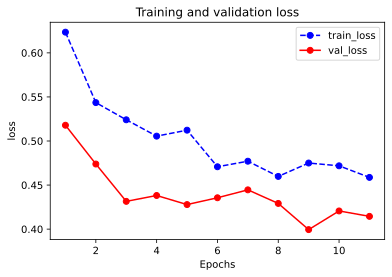

In [23]:
plot_metric(dfhistory,"loss")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h426f4kjqfj20fy0a9q3a.jpg)


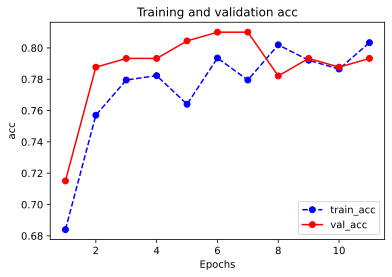

In [24]:
plot_metric(dfhistory,"acc")

![](https://tva1.sinaimg.cn/large/e6c9d24egy1h426dvo2upj20fy0a9t92.jpg)

### 五，使用模型

In [25]:
#预测概率

# tensor([[0.1548],
#         [0.7443],
#         [0.4360],
#         [0.9994],
#         [0.6491],
#         [0.9156],
#         [0.1610],
#         [0.9375],
#         [0.6689],
#         [0.1827]])
y_pred_probs = torch.sigmoid(net(torch.tensor(x_test[0:10]).float())).data
y_pred_probs

tensor([[0.1548],
        [0.7443],
        [0.4360],
        [0.9994],
        [0.6491],
        [0.9156],
        [0.1610],
        [0.9375],
        [0.6689],
        [0.1827]])

```
tensor([[0.1146],
        [0.6517],
        [0.4307],
        [0.8692],
        [0.5542],
        [0.7894],
        [0.1096],
        [0.7125],
        [0.6027],
        [0.1139]])
```

In [26]:
#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
y_pred

tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

```
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])
```

### 六，保存模型

Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。

第一种方法只保存模型参数。

第二种方法保存完整模型。

推荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。


**1，保存模型参数(推荐)**

In [27]:
print(net.state_dict().keys())

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


```
odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])
```

In [28]:
# tensor.data的两点总结：
# （1）tensor .data 返回和 x 的相同数据 tensor,而且这个新的tensor和原来的tensor是共用数据的，一者改变，另一者也会跟着改变，而且新分离得到的tensor的require s_grad = False, 即不可求导的。（这一点其实detach是一样的）
# （2）使用tensor.data的局限性。文档中说使用tensor.data是不安全的, 因为 x.data 不能被 autograd 追踪求微分 。什么意思呢？从上面的例子可以看出，由于我更改分离之后的变量值c,导致原来的张量out的值也跟着改变了，但是这种改变对于autograd是没有察觉的，它依然按照求导规则来求导，导致得出完全错误的导数值却浑然不知。它的风险性就是如果我再任意一个地方更改了某一个张量，求导的时候也没有通知我已经在某处更改了，导致得出的导数值完全不正确，故而风险大。

# tensor.detach()的两点总结：
# （1）tensor .detach() 返回和 x 的相同数据 tensor,而且这个新的tensor和原来的tensor是共用数据的，一者改变，另一者也会跟着改变，而且新分离得到的tensor的require s_grad = False, 即不可求导的。（这一点其实 .data是一样的）
# （2）使用tensor.detach()的优点。从上面的例子可以看出，由于我更改分离之后的变量值c,导致原来的张量out的值也跟着改变了，这个时候如果依然按照求导规则来求导，由于out已经更改了，所以不会再继续求导了，而是报错，这样就避免了得出完全牛头不对马嘴的求导结果。

# 相同点：tensor.data和tensor.detach() 都是变量从图中分离，但而这都是“原位操作 inplace operation”。
# 不同点：
# （1）.data 是一个属性，二.detach()是一个方法；
# （2）.data 是不安全的，.detach()是安全的。

In [29]:
# 保存模型参数

torch.save(net.state_dict(), "./data/net_parameter.pt")

net_clone = create_net()
net_clone.load_state_dict(torch.load("./data/net_parameter.pt"))

assert (torch.sigmoid(net_clone.forward(torch.tensor(x_test[0:10]).float())).detach() == y_pred_probs).all()


```
tensor([[0.1146],
        [0.6517],
        [0.4307],
        [0.8692],
        [0.5542],
        [0.7894],
        [0.1096],
        [0.7125],
        [0.6027],
        [0.1139]])
```

**2，保存完整模型(不推荐)**

In [30]:

torch.save(net, './data/net_model.pt')
net_loaded = torch.load('./data/net_model.pt')
torch.sigmoid(net_loaded(torch.tensor(x_test[0:10]).float())).data

assert (torch.sigmoid(net_loaded(torch.tensor(x_test[0:10]).float())).detach() == y_pred_probs).all()

```
tensor([[0.1146],
        [0.6517],
        [0.4307],
        [0.8692],
        [0.5542],
        [0.7894],
        [0.1096],
        [0.7125],
        [0.6027],
        [0.1139]])
```

In [31]:
# 2023-05-26 23:20:22:spent 14.959 秒
end_time = time.time()
print_with_time("spent {}".format(get_time_interval_str(end_time - start_time)))

2023-05-26 23:20:22:spent 14.959 秒


**如果本书对你有所帮助，想鼓励一下作者，记得给本项目加一颗星星star⭐️，并分享给你的朋友们喔😊!** 

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"算法美食屋"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![算法美食屋logo.png](https://tva1.sinaimg.cn/large/e6c9d24egy1h41m2zugguj20k00b9q46.jpg)